<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/ImageGPT/(Un)conditional_image_generation_with_ImageGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting-up environment

We first install HuggingFace Transformers.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 59 kB 5.8 MB/s 
     |████████████████████████████████| 3.3 MB 25.7 MB/s 
     |████████████████████████████████| 596 kB 67.1 MB/s 
     |████████████████████████████████| 895 kB 58.6 MB/s 


## Unconditional image generation

Next, we initialize the feature extractor and model, and put the model on the GPU.

In [2]:
from transformers import ImageGPTFeatureExtractor, ImageGPTForCausalLM
import numpy as np
import torch

feature_extractor = ImageGPTFeatureExtractor.from_pretrained('openai/imagegpt-medium')
model = ImageGPTForCausalLM.from_pretrained('openai/imagegpt-medium')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

Downloading:   0%|          | 0.00/46.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/561 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

ImageGPTForCausalLM(
  (transformer): ImageGPTModel(
    (wte): Embedding(513, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): ImageGPTBlock(
        (ln_1): ImageGPTLayerNorm()
        (attn): ImageGPTAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): ImageGPTLayerNorm()
        (mlp): ImageGPTMLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): ImageGPTBlock(
        (ln_1): ImageGPTLayerNorm()
        (attn): ImageGPTAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): ImageGPTLayerNorm()
        (mlp): ImageGPTMLP(
          

Here we only feed the start of sequence (SOS) special token to the model, and let it generate 32x32 = 1024 pixel values using the `generate()` method. Each pixel value is one of 512 possible color clusters.

In [3]:
# unconditional generation of 8 images
batch_size = 8
context = torch.full((batch_size, 1), model.config.vocab_size - 1) #initialize with SOS token (with ID 512)
context = torch.tensor(context).to(device)
output = model.generate(input_ids=context, max_length=model.config.n_positions + 1, temperature=1.0, do_sample=True, top_k=40)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


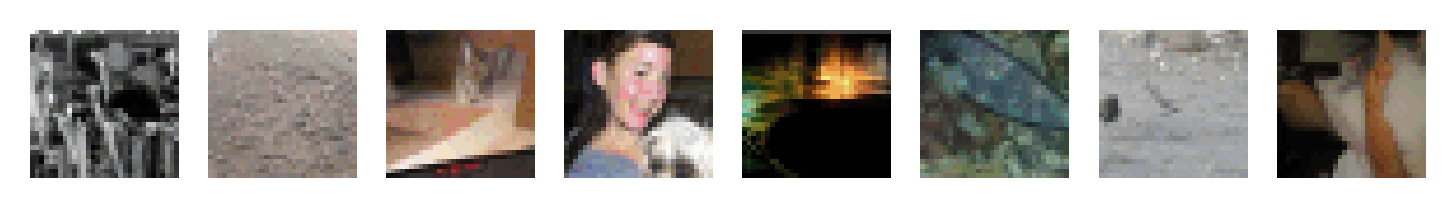

In [4]:
#visualize samples with Image-GPT color palette.
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

clusters = feature_extractor.clusters
n_px = feature_extractor.size

samples = output[:,1:].cpu().detach().numpy()
samples_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [32, 32, 3]).astype(np.uint8) for s in samples] # convert color cluster tokens back to pixels
f, axes = plt.subplots(1, batch_size, dpi=300)

for img, ax in zip(samples_img, axes):
    ax.axis('off')
    ax.imshow(img)

# Tokenize Cropped Images for Image Completion

Given the upper half part of an image, it's interesting to see how ImageGPT would complete it. 

Let's check 8 completions for a given image. 

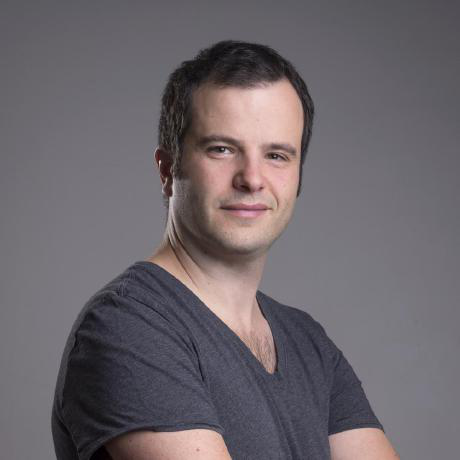

In [5]:
import requests
from PIL import Image

url = 'https://assetsnffrgf-a.akamaihd.net/assets/m/502013285/univ/art/502013285_univ_sqr_xl.jpg'
url = "https://avatars.githubusercontent.com/u/326577?v=4"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
image

We prepare the images using ImageGPTFeatureExtractor, which will resize each image to 32x32x3, normalize it and then apply color clustering. Finally, it will flatten the pixel values out to a long list of 32x32 = 1024 values. 

In [6]:
encoding = feature_extractor([image for _ in range(8)], return_tensors="pt")
print(encoding.keys())

dict_keys(['pixel_values'])


In [7]:
encoding.pixel_values.shape

torch.Size([8, 1024])

Next, we only keep the first 512 tokens (pixel values).

In [8]:
samples = encoding.pixel_values.numpy()
n_px_crop = 16
# crop top n_px_crop rows. These will be the conditioning tokens
primers = samples[:,:n_px_crop*n_px] 

In [9]:
print(primers.shape)

(8, 512)


We can visualize both the original (lower-resolution and color-clustered) images and the cropped ones:

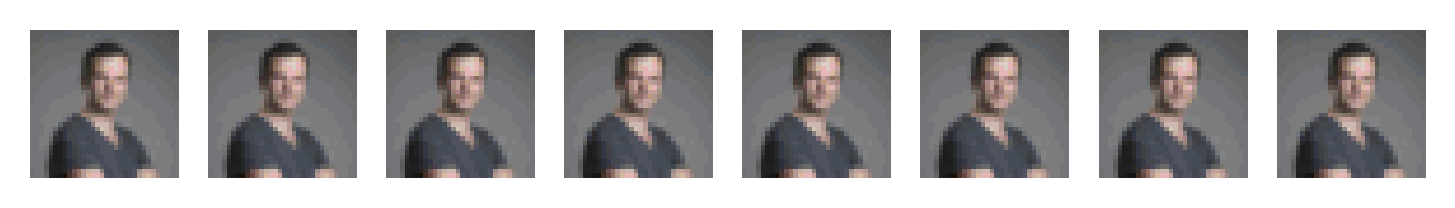

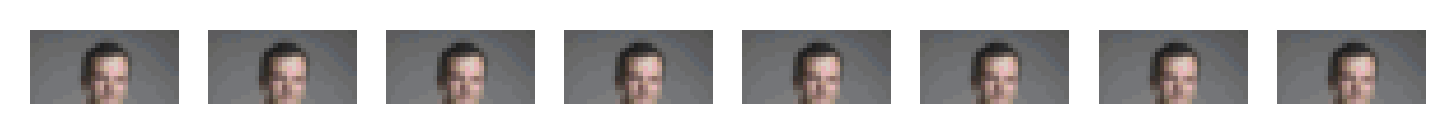

In [10]:
#visualize samples and crops with Image-GPT color palette. Should look similar to original resized images
samples_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [n_px, n_px, 3]).astype(np.uint8) for s in samples] # convert color clusters back to pixels
primers_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [n_px_crop,n_px, 3]).astype(np.uint8) for s in primers] # convert color clusters back to pixels

f, axes = plt.subplots(1, batch_size, dpi=300)
for img,ax in zip(samples_img, axes):
    ax.axis('off')
    ax.imshow(img)

f, axes2 = plt.subplots(1, batch_size, dpi=300)
for img,ax in zip(primers_img, axes2):
    ax.axis('off')
    ax.imshow(img)

# Conditional Image Completion

Let's let ImageGPT complete the rest! For this, we also add the start token. Note that we can leverage all possibilities of HuggingFace's generate() method, which are explained in detail in [this blog post](https://huggingface.co/blog/how-to-generate).

In [11]:
context = np.concatenate((np.full((batch_size, 1), model.config.vocab_size - 1), primers), axis=1)
context = torch.tensor(context).to(device)
output = model.generate(input_ids=context, max_length=n_px*n_px + 1, temperature=1.0, do_sample=True, top_k=40)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


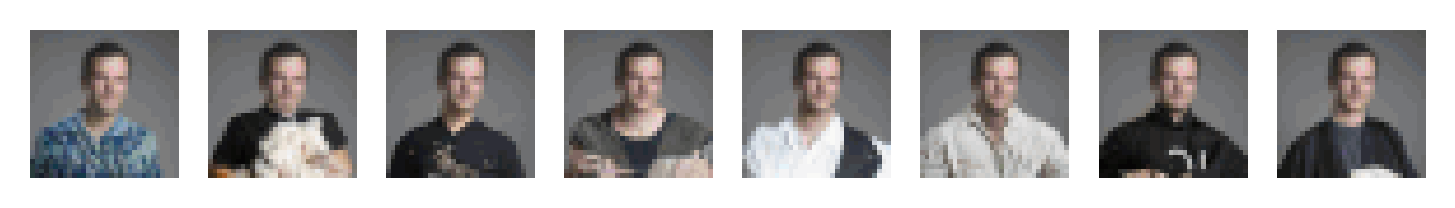

In [12]:
#visualize samples with Image-GPT color palette. 
samples = output[:,1:].cpu().detach().numpy()
samples_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [n_px, n_px, 3]).astype(np.uint8) for s in samples] # convert color cluster tokens back to pixels
f, axes = plt.subplots(1, batch_size, dpi=300)

for img,ax in zip(samples_img, axes):
    ax.axis('off')
    ax.imshow(img)

## Gradio demo

In [13]:
!pip install -q gradio

     |████████████████████████████████| 2.0 MB 15.8 MB/s 
     |████████████████████████████████| 206 kB 68.7 MB/s 
     |████████████████████████████████| 1.9 MB 59.7 MB/s 
     |████████████████████████████████| 3.5 MB 58.5 MB/s 
     |████████████████████████████████| 961 kB 57.3 MB/s 
     |████████████████████████████████| 63 kB 3.0 MB/s 


In [15]:
import os
os.system('pip install git+https://github.com/huggingface/transformers --upgrade')

import gradio as gr
from transformers import ImageGPTFeatureExtractor, ImageGPTForCausalLM
import torch
import numpy as np
import requests
from PIL import Image
import matplotlib.pyplot as plt

feature_extractor = ImageGPTFeatureExtractor.from_pretrained("openai/imagegpt-small")
model = ImageGPTForCausalLM.from_pretrained("openai/imagegpt-small")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# load image examples
urls = ['https://assetsnffrgf-a.akamaihd.net/assets/m/502013285/univ/art/502013285_univ_sqr_xl.jpg']
for idx, url in enumerate(urls):
  image = Image.open(requests.get(url, stream=True).raw)
  image.save(f"image_{idx}.png")

def process_image(image):
    # prepare 8 images, shape (8, 1024)
    encoding = feature_extractor([image for _ in range(8)], return_tensors="pt")

    # create primers
    samples = encoding.pixel_values.numpy()
    n_px = feature_extractor.size
    n_px_crop = 16
    primers = samples.reshape(-1,n_px*n_px)[:,:n_px_crop*n_px] # crop top n_px_crop rows. These will be the conditioning tokens
    
    # generate (no beam search)
    context = np.concatenate((np.full((batch_size, 1), model.config.vocab_size - 1), primers), axis=1)
    context = torch.tensor(context).to(device)
    output = model.generate(input_ids=context, max_length=n_px*n_px + 1, temperature=1.0, do_sample=True, top_k=40)

    # decode back to images
    samples = output[:,1:].cpu().detach().numpy()
    samples_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [n_px, n_px, 3]).astype(np.uint8) for s in samples] # convert color cluster tokens back to pixels
    
    # save as list of files
    completions = []
    output_dir = '.'
    for i in range(len(samples_img)):
      fname = os.path.join(output_dir, "completion" + str(i) + ".png")
      plt.imsave(fname=fname, arr=samples_img[i], format='png')
      completions.append(fname)

    return completions

title = "Interactive demo: ImageGPT"
description = "Demo for OpenAI's ImageGPT: Generative Pretraining from Pixels. To use it, simply upload an image or use the example image below and click 'submit'. Results will show up in a few seconds."
article = "<p style='text-align: center'><a href='https://arxiv.org/abs/2109.10282'>ImageGPT: Generative Pretraining from Pixels</a> | <a href='https://openai.com/blog/image-gpt/'>Official blog</a></p>"
examples =[["image_0.png"]]

iface = gr.Interface(fn=process_image, 
                     inputs=gr.inputs.Image(type="pil"), 
                     outputs=[gr.outputs.Image(type='file', label=f'completion_{i}') for i in range(8)],
                     title=title,
                     description=description,
                     article=article,
                     examples=examples)
iface.launch(debug=True)

Downloading:   0%|          | 0.00/46.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/560 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/317M [00:00<?, ?B/s]

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://36254.gradio.app

This share link will expire in 72 hours. To get longer links, send an email to: support@gradio.app


KeyboardInterrupt: ignored

## Verifying code examples

Here we verify whether the code examples in the docs of ImageGPT work fine.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


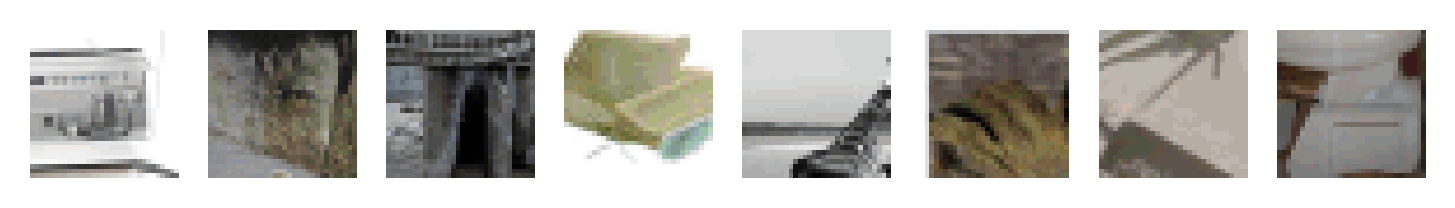

In [16]:
from transformers import ImageGPTFeatureExtractor, ImageGPTForCausalLM
import torch
import matplotlib.pyplot as plt
import numpy as np

feature_extractor = ImageGPTFeatureExtractor.from_pretrained('openai/imagegpt-small')
model = ImageGPTForCausalLM.from_pretrained('openai/imagegpt-small')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# unconditional generation of 8 images
batch_size = 8
context = torch.full((batch_size, 1), model.config.vocab_size - 1) #initialize with SOS token
context = torch.tensor(context).to(device)
output = model.generate(input_ids=context, max_length=model.config.n_positions + 1, temperature=1.0, do_sample=True, top_k=40)

clusters = feature_extractor.clusters
n_px = feature_extractor.size

samples = output[:,1:].cpu().detach().numpy()
samples_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [n_px, n_px, 3]).astype(np.uint8) for s in samples] # convert color cluster tokens back to pixels
f, axes = plt.subplots(1, batch_size, dpi=300)

for img, ax in zip(samples_img, axes):
   ax.axis('off')
   ax.imshow(img)

In [17]:
from transformers import ImageGPTFeatureExtractor, ImageGPTForImageClassification
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

feature_extractor = ImageGPTFeatureExtractor.from_pretrained('openai/imagegpt-small')
model = ImageGPTForImageClassification.from_pretrained('openai/imagegpt-small')

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits

Some weights of the model checkpoint at openai/imagegpt-small were not used when initializing ImageGPTForImageClassification: ['lm_head.weight']
- This IS expected if you are initializing ImageGPTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ImageGPTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ImageGPTForImageClassification were not initialized from the model checkpoint at openai/imagegpt-small and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
logits.shape

torch.Size([1, 2])

In [19]:
from transformers import ImageGPTFeatureExtractor, ImageGPTModel
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

feature_extractor = ImageGPTFeatureExtractor.from_pretrained('openai/imagegpt-small')
model = ImageGPTModel.from_pretrained('openai/imagegpt-small')

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)

Some weights of the model checkpoint at openai/imagegpt-small were not used when initializing ImageGPTModel: ['lm_head.weight']
- This IS expected if you are initializing ImageGPTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ImageGPTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
outputs.last_hidden_state.shape

torch.Size([1, 1024, 512])